In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
np.random.seed(1)

In [2]:
def train_test_split(X,y,test_split):
    assert(X.shape[1]==y.shape[1])
    assert((test_split>0)&(test_split<1))

    obs = X.shape[1]
    test_obs = int(np.ceil(test_split*obs))
    
    test_index = np.random.choice(range(obs),test_obs,replace=False)
    train_index = np.array([r for r in range(obs) if r not in(test_index)])
    
    X_train = X[:,train_index]
    X_test  = X[:,test_index]
    y_train = y[:,train_index]
    y_test  = y[:,test_index]
    
    return(X_train,X_test,y_train,y_test)

(2, 10000) (1, 10000)


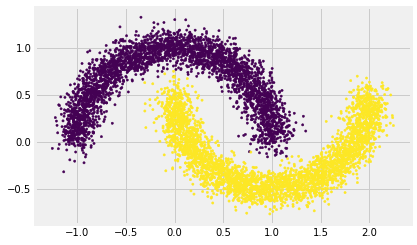

In [3]:
#np.random.seed(24)
moons=10000
X, y = sklearn.datasets.make_moons(moons, noise=.1)
X = X.T
y = y.reshape(1,y.shape[0])
df = pd.DataFrame({'x1':X[0],'x2':X[1],'y':np.squeeze(y)})
print(X.shape,y.shape)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_split=0.33)
plt.scatter(X_train[0], X_train[1], s=5, c=np.squeeze(y_train), cmap='viridis')


Training Size X: 6700 	 Training Size y: 6700
Test Size X: 3300 	 Test Size y: 3300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
x1    10000 non-null float64
x2    10000 non-null float64
y     10000 non-null int64
dtypes: float64(2), int64(1)
memory usage: 234.5 KB
None


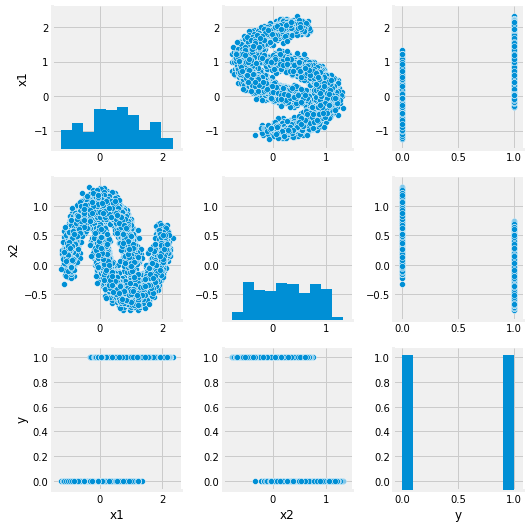

In [4]:
print(('Training Size X: %s \t Training Size y: %s') % (X_train.shape[1], y_train.shape[1]))
print(('Test Size X: %s \t Test Size y: %s') % (X_test.shape[1], y_test.shape[1]))
print(df.info())
sns.pairplot(df)

In [5]:
# Define Model Parameters
# This model only has an input layer and an output layer
layers = {
    0:{'size':X_train.shape[0],
       'activation':None},
    1:{'size':100,
       'activation':'relu'},
    2:{'size':1,
       'activation':'sigmoid'}
}  
print(layers)

{0: {'size': 2, 'activation': None}, 1: {'size': 100, 'activation': 'relu'}, 2: {'size': 1, 'activation': 'sigmoid'}}


In [6]:
def sigmoid(x):
    '''
    ACCEPTS: numeric x
    RETURNS: sigmoid of x
    '''
    return(1/(1+np.exp(-x)))

def relu(x):
    return(np.maximum(x,0))

In [7]:
def initialize(layers):
    '''
    ACCEPTS: layers dict
    RETURNS: initialized W and B vectors for Layers 1 through L
    '''
    params = {}
    for i in range(0,len(layers)):
        if (i) == 0: pass
        else: 
            layer_num = i            
            weight_name = ''.join(['W',str(layer_num)])
            bias_name = ''.join(['b',str(layer_num)])
            params[weight_name] = np.random.rand(layers[i]['size'],layers[i-1]['size'])*.1
            params[bias_name] = np.zeros((layers[i]['size'],1))
    return(params)

In [8]:
def activation_forward(Zᴸ,activation_method='relu'):    
    if activation_method=='sigmoid':
        Aᴸ = sigmoid(Zᴸ)
    elif activation_method=='relu':
        Aᴸ = relu(Zᴸ)
    return(Aᴸ)

def activation_backward(dAᴸ,Zᴸ,activation_method):
    if activation_method=='sigmoid':
        s = 1/(1+np.exp(-Zᴸ))
        dZᴸ = dAᴸ * s * (1-s)
        assert(dZᴸ.shape == Zᴸ.shape)

    elif activation_method=='relu':
        dZᴸ = np.array(dAᴸ, copy=True) 
        dZᴸ[Zᴸ <= 0] = 0
        assert(dZᴸ.shape == Zᴸ.shape)
        
    return(dZᴸ)

In [9]:
def calculate_cost(A,y):
    m = y.shape[0]
    cost = (-1/m)*np.sum(np.multiply(np.log(A),y) + np.multiply((1-y),np.log(1-A)))
    return(cost)

In [10]:
def model(layers,X_train,y_train,α=.01,iterations=1000):
    
    params = initialize(layers)
    params['A0'] = X_train
    m = y_train.shape[0]
    cost = []
    
    for i in range(iterations):
        # forward
        for l in range(1,len(layers)):
            Wᴸ = params[''.join(['W',str(l)])]
            Aᴶ = params[''.join(['A',str(l-1)])]    # Aᴶ is the previous activation
            bᴸ = params[''.join(['b',str(l)])]

            Zᴸ = np.dot(Wᴸ,Aᴶ) + bᴸ
            Aᴸ = activation_forward(Zᴸ,layers[l]['activation'])

            params[''.join(['A',str(l)])] = Aᴸ
            params[''.join(['Z',str(l)])] = Zᴸ

        if i%100==0:
            c = calculate_cost(Aᴸ,y_train)
            print(c)
            cost.append([i,c])

        params[''.join(['dA',str(l)])] = -(np.divide(y_train, Aᴸ) - np.divide(1 - y_train, 1 - Aᴸ))

        # backward
        for l in reversed(range(1,len(layers))):
            dAᴸ = params[''.join(['dA',str(l)])]        
            Zᴸ  = params[''.join(['Z',str(l)])]
            Aᴶ  = params[''.join(['A',str(l-1)])]
            Wᴸ  = params[''.join(['W',str(l)])]

            dZᴸ = activation_backward(dAᴸ,Zᴸ,layers[l]['activation'])
            dWᴸ = (1/m)*np.dot(dZᴸ,Aᴶ.T)
            dAᴶ = np.dot(Wᴸ.T,dZᴸ)
            dbᴸ = (1/m)*np.sum(dZᴸ,axis=1,keepdims=True)

            params[''.join(['dZ',str(l)])] = dZᴸ
            params[''.join(['dW',str(l)])] = dWᴸ
            params[''.join(['db',str(l)])] = dbᴸ
            params[''.join(['dA',str(l-1)])] = dAᴶ

        # update 
        for l in range(1,len(layers)):
            Wᴸ  = params[''.join(['W',str(l)])]
            bᴸ  = params[''.join(['b',str(l)])]
            dWᴸ = params[''.join(['dW',str(l)])]
            dbᴸ = params[''.join(['db',str(l)])]

            Wᴸ = Wᴸ - (α*dWᴸ)
            bᴸ = bᴸ - (α*dbᴸ)

            params[''.join(['W',str(l)])] = Wᴸ
            params[''.join(['b',str(l)])] = bᴸ

    m = { k:v for k,v in params.items() if (k[0] in(['W','b']) and int(k[1]) > 0)}
    return(m,cost)


In [11]:
m,cost = model(layers,X_train,y_train,.0001,5000)

4634.48904411
1640.60271854
1495.34765055
1171.19887928
672.041066457
397.417991247
273.72401741
209.594133786
171.44732367
146.294584177
128.478593742
115.10282554
104.719402987
96.4116402901
89.5716581647
83.8433322384
78.9536434096
74.7568611671
71.0693599246
67.8012225761
64.8925604439
62.2889814795
59.9380445725
57.7783437029
55.81177575
53.9534952353
52.2169651734
50.5906125715
49.0959856343
47.7195609329
46.4319089304
45.2320706553
44.1303862949
43.1027873257
42.1389284277
41.2486481049
40.4172747488
39.6337594624
38.8936186826
38.193097865
37.5203219599
36.8762643388
36.2604436692
35.6694542333
35.1043932778
34.5639912669
34.0469250551
33.5510372399
33.0839111261
32.6384625617


Text(0.5,1,'Cost Function')

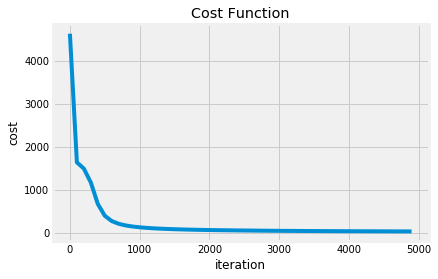

In [12]:
i = [ l[0] for l in cost ]
c = [ l[1] for l in cost ]

plt.plot(i, c)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.title('Cost Function')

In [13]:
def predict(model,layers,X,y,threshold):
    m = model.copy()
    m['A0'] = X
    for l in range(1,len(layers)):
        Wᴸ = m[''.join(['W',str(l)])]
        Aᴶ = m[''.join(['A',str(l-1)])]    # Aᴶ is the previous activation
        bᴸ = m[''.join(['b',str(l)])]

        Zᴸ = np.dot(Wᴸ,Aᴶ) + bᴸ
        Aᴸ = activation_forward(Zᴸ,layers[l]['activation'])
        
        m[''.join(['A',str(l)])] = Aᴸ
        m[''.join(['Z',str(l)])] = Zᴸ
        
    ŷ = np.squeeze(np.where(Aᴸ>threshold,1,0))
    accuracy = ((100 - np.mean(np.abs(ŷ - y)) * 100))    
    return(ŷ,accuracy)

In [14]:
# optimize threshold
thresholds = []
for t in np.multiply(range(100),.01):
    _,acc = predict(m,layers,X_train,y_train,t)
    thresholds.append([t,acc])    

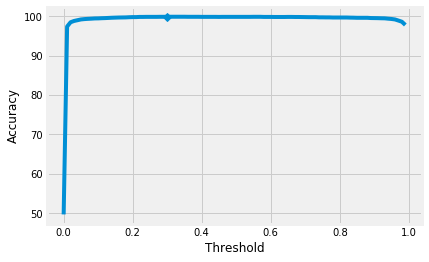

In [15]:
t,a = [ t[0] for t in thresholds ],[ t[1] for t in thresholds ]
plt.plot(t,a,'-D', markevery=[a.index(max(a))])
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
optimal_threshold = t[a.index(max(a))]

In [16]:
threshold=optimal_threshold
predict_train, accuracy_train = predict(m,layers,X_train,y_train,optimal_threshold)
predict_test, accuracy_test = predict(m,layers,X_test,y_test,optimal_threshold)

print('Train Accuracy: %g%%' % accuracy_train)
print('Test Accuracy: %g%%' % accuracy_test)

Train Accuracy: 99.9104%
Test Accuracy: 99.8788%


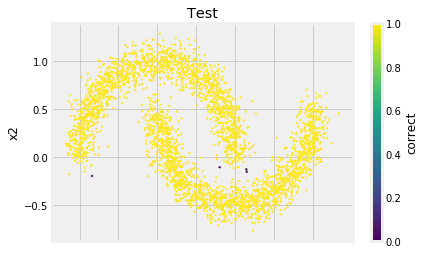

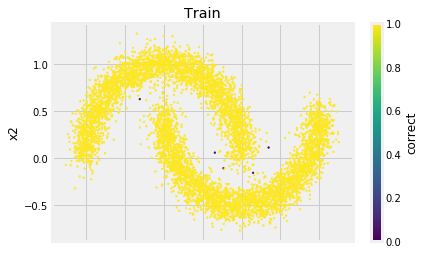

In [17]:
train_df = pd.DataFrame({'x1':X_train[0],'x2':X_train[1],'y':np.squeeze(y_train),'ŷ':predict_train})
train_df['correct'] = train_df['y']==train_df['ŷ']
test_df = pd.DataFrame({'x1':X_test[0],'x2':X_test[1],'y':np.squeeze(y_test),'ŷ':predict_test})
test_df['correct'] = test_df['y']==test_df['ŷ']

# plot the incorrect data classifications
test_df.plot.scatter(x='x1',y='x2',s=3,c='correct',cmap='viridis',title='Test')
train_df.plot.scatter(x='x1',y='x2',s=3,c='correct',cmap='viridis',title='Train')

In [18]:
import pprint
pprint.pprint(m)

{'W1': array([[ 0.47522837, -0.28166039],
       [ 0.71110158, -0.42647927],
       [ 0.37598253, -0.22086273],
       [ 1.73782809,  0.20456935],
       [ 2.24534549,  0.6812126 ],
       [ 0.38575354, -0.21904808],
       [-0.35215191,  0.56500081],
       [ 0.46830945, -0.12847769],
       [ 0.54248429, -0.33090249],
       [ 0.64245332, -0.39057033],
       [ 0.66469083, -0.40014006],
       [ 0.8072428 , -0.48446891],
       [ 0.32579156, -0.18252151],
       [ 0.84462894, -0.1445036 ],
       [ 0.69854509, -0.42330215],
       [ 0.69509776, -0.42196962],
       [ 0.44959107, -0.26452729],
       [ 0.28511072,  0.10302529],
       [ 0.16445608, -0.08855836],
       [ 0.37255059, -0.22486794],
       [ 0.52477621, -0.31544198],
       [-0.20592206,  0.33760771],
       [ 0.33443325, -0.19692003],
       [ 2.35594562,  0.46451496],
       [ 0.26966326, -0.16279516],
       [-0.09806517,  0.23411274],
       [ 0.13884961, -0.08984704],
       [-0.1949887 ,  0.31914828],
       [ 0.47